In [1]:
import fastai

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [3]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CPU


In [4]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [5]:
from pathlib import Path

src_base_path = Path('dishes')
dest_base_path = Path('images')
cats = ['炒合菜', '葱爆羊肉', '地三鲜', '豆角炒肉', '腐竹烧肉', '锅包肉', '红烧带鱼', '红烧排骨', '虎皮青椒', '酱爆鸡丁', '酱爆茄子', '酱大骨', '酱烧豆腐', '椒盐平菇', '京酱肉丝', '韭菜炒豆干', '烤麸烧香菇', '腊肠炒荷兰豆', '辣炒鸡胗', '辣炒藕丁', '凉拌拉皮', '溜肉段', '梅菜扣肉', '芹菜炒香干', '青椒炒肥肠', '青蒜炒腊肉', '清炒西兰花', '肉末粉条', '四喜丸子', '蒜泥白肉', '蒜蓉粉丝娃娃菜', '蒜苔炒肉丝', '糖醋里脊', '五香熏鱼', '西葫芦炒鸡蛋', '香椿拌豆腐', '香辣虾', '洋葱炒猪肝', '油焖笋', '鱼香肉丝']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: 炒合菜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 葱爆羊肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 地三鲜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 豆角炒肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 腐竹烧肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 锅包肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 红烧带鱼
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 红烧排骨
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 虎皮青椒
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 酱爆鸡丁
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 酱爆茄子
Total files: 49
Train set: 29 files
Valid set: 9 files
Test set: 11 files

Category: 酱大骨
Total fi

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64)

d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 33465 (\N{CJK UNIFIED IDEOGRAPH-82B9}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 33756 (\N{CJK UNIFIED IDEOGRAPH-83DC}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 28818 (\N{CJK UNIFIED IDEOGRAPH-7092}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20937 (\N{C

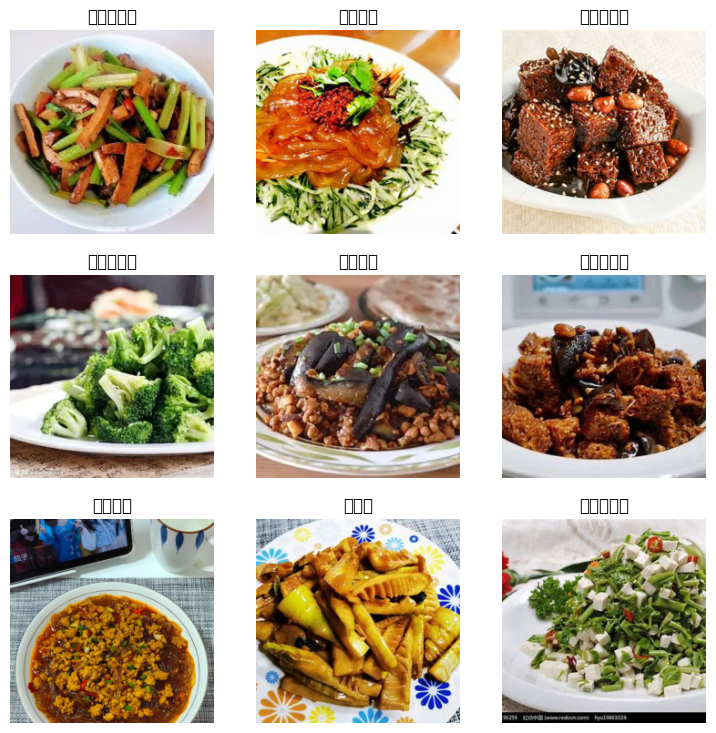

In [7]:
dls.show_batch()

In [8]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [9]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [10]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,5.210469,3.286513,0.168724,01:53


Better model found at epoch 0 with valid_loss value: 3.286513090133667.


epoch,train_loss,valid_loss,accuracy,time
0,3.439093,2.679048,0.300412,02:04
1,3.017493,2.302158,0.403292,02:27
2,2.637249,2.000849,0.473251,02:15
3,2.296377,1.761780,0.506173,02:18
4,1.990203,1.565582,0.555556,02:15
5,1.720320,1.402116,0.633745,02:26
6,1.487067,1.268858,0.654321,02:17
7,1.277856,1.162625,0.679012,02:16
8,1.069700,1.083207,0.691358,02:13
9,0.906952,1.024923,0.691358,02:10


Better model found at epoch 0 with valid_loss value: 2.6790475845336914.
Better model found at epoch 1 with valid_loss value: 2.3021581172943115.
Better model found at epoch 2 with valid_loss value: 2.000849485397339.
Better model found at epoch 3 with valid_loss value: 1.7617796659469604.
Better model found at epoch 4 with valid_loss value: 1.5655823945999146.
Better model found at epoch 5 with valid_loss value: 1.4021161794662476.
Better model found at epoch 6 with valid_loss value: 1.2688575983047485.
Better model found at epoch 7 with valid_loss value: 1.1626248359680176.
Better model found at epoch 8 with valid_loss value: 1.083207368850708.
Better model found at epoch 9 with valid_loss value: 1.0249230861663818.
Better model found at epoch 10 with valid_loss value: 0.9843624830245972.
Better model found at epoch 11 with valid_loss value: 0.9559733271598816.
Better model found at epoch 12 with valid_loss value: 0.9157304763793945.
Better model found at epoch 13 with valid_loss val

In [11]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.7673469185829163.


In [22]:
loss

0.7388275861740112

d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 29071 (\N{CJK UNIFIED IDEOGRAPH-718F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\trae\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 37233 (\N{CJK UNIFIED IDEOGRAPH-9171})

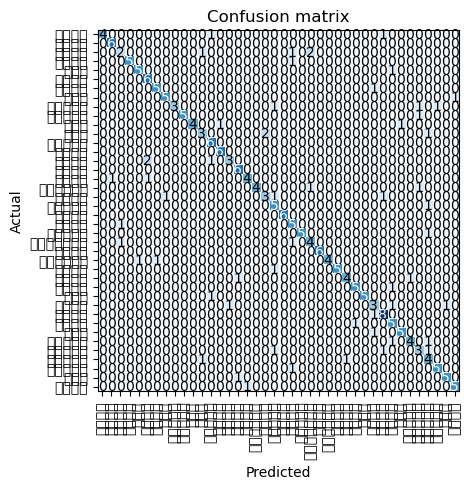

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

        五香熏鱼       1.00      0.67      0.80         6
        京酱肉丝       0.86      1.00      0.92         6
        凉拌拉皮       0.50      0.33      0.40         6
        四喜丸子       1.00      0.83      0.91         6
         地三鲜       0.83      0.83      0.83         6
        梅菜扣肉       0.67      1.00      0.80         6
        椒盐平菇       0.83      0.83      0.83         6
         油焖笋       0.83      0.83      0.83         6
       洋葱炒猪肝       1.00      0.50      0.67         6
       清炒西兰花       1.00      0.83      0.91         6
         溜肉段       1.00      0.67      0.80         6
         炒合菜       0.60      0.50      0.55         6
       烤麸烧香菇       0.67      1.00      0.80         6
        糖醋里脊       0.86      1.00      0.92         6
        红烧带鱼       0.75      0.50      0.60         6
        红烧排骨       0.75      1.00      0.86         6
        肉末粉条       0.80      0.67      0.73         6
      腊肠炒荷兰豆       1.00    

d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 32905 (\N{CJK UNIFIED IDEOGRAPH-8089}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26411 (\N{CJK UNIFIED IDEOGRAPH-672B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\trae\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39321 (\N{C

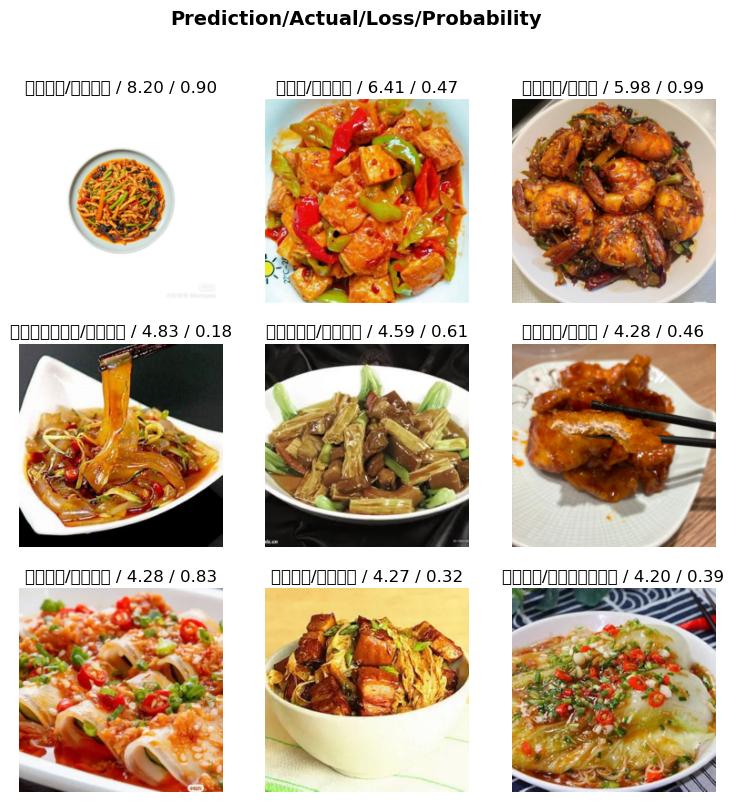

In [15]:
interp.plot_top_losses(9)

In [38]:
from fastai.vision.augment import aug_transforms
from fastai.vision.data import DataBlock, ImageBlock, CategoryBlock
from fastai.data.transforms import GrandparentSplitter
from fastai.vision.utils import get_image_files
from fastai.vision.learner import Learner
import json

# 在 DataBlock 中补充数据增强（如随机裁剪、翻转）
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.8)  # 新增数据增强
)

 

In [39]:
# 假设 learn 已正确定义并完成训练，这里只是示例保留导出代码
learn.export('dish.pkl')

In [45]:
import os
import json

image_folder_path = 'dishes'
folders = [f for f in os.listdir(image_folder_path) if not f.startswith('.')]  # 过滤掉以.开头的文件和文件夹
folders.sort()

dish_id_map = {name: i + 1 for i, name in enumerate(folders)}
with open('dish_id_mapss.json', 'w', encoding='utf-8') as f:
    json.dump(dish_id_map, f, ensure_ascii=False, indent=4)

In [18]:
# 获取分类模型的类别列表并保存映射关系
dish_names = dls.vocab  # dls 需是已定义的 DataLoaders 对象
dish_id_map = {name: i+1 for i, name in enumerate(dish_names)}
with open('dish_id_map.json', 'w', encoding='utf-8') as f:
    json.dump(dish_id_map, f, ensure_ascii=False, indent=2)

In [25]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [26]:
learn.export('dish.pkl')

In [2]:
import os
import json
import locale

# 设置区域设置为UTF - 8
locale.setlocale(locale.LC_ALL, 'zh_CN.UTF-8') 

folder_path = 'dishes'
all_entries = os.listdir(folder_path)
print("目录下所有条目:", all_entries)
folders = [f for f in all_entries if os.path.isdir(os.path.join(folder_path, f))]
folders.sort(key=locale.strxfrm)  # 使用locale的排序规则
print("筛选后的文件夹:", folders)
dish_id_map = {name: i + 1 for i, name in enumerate(folders)}
with open('dish_id_map.json', 'w', encoding='utf-8') as f:
    json.dump(dish_id_map, f, ensure_ascii=False, indent=4)

目录下所有条目: ['五香熏鱼', '京酱肉丝', '凉拌拉皮', '四喜丸子', '地三鲜', '梅菜扣肉', '椒盐平菇', '油焖笋', '洋葱炒猪肝', '清炒西兰花', '溜肉段', '炒合菜', '烤麸烧香菇', '糖醋里脊', '红烧带鱼', '红烧排骨', '肉末粉条', '腊肠炒荷兰豆', '腐竹烧肉', '芹菜炒香干', '葱爆羊肉', '蒜泥白肉', '蒜苔炒肉丝', '蒜蓉粉丝娃娃菜', '虎皮青椒', '西葫芦炒鸡蛋', '豆角炒肉', '辣炒藕丁', '辣炒鸡胗', '酱大骨', '酱烧豆腐', '酱爆茄子', '酱爆鸡丁', '锅包肉', '青椒炒肥肠', '青蒜炒腊肉', '韭菜炒豆干', '香椿拌豆腐', '香辣虾', '鱼香肉丝']
筛选后的文件夹: ['炒合菜', '葱爆羊肉', '地三鲜', '豆角炒肉', '腐竹烧肉', '锅包肉', '红烧带鱼', '红烧排骨', '虎皮青椒', '酱爆鸡丁', '酱爆茄子', '酱大骨', '酱烧豆腐', '椒盐平菇', '京酱肉丝', '韭菜炒豆干', '烤麸烧香菇', '腊肠炒荷兰豆', '辣炒鸡胗', '辣炒藕丁', '凉拌拉皮', '溜肉段', '梅菜扣肉', '芹菜炒香干', '青椒炒肥肠', '青蒜炒腊肉', '清炒西兰花', '肉末粉条', '四喜丸子', '蒜泥白肉', '蒜蓉粉丝娃娃菜', '蒜苔炒肉丝', '糖醋里脊', '五香熏鱼', '西葫芦炒鸡蛋', '香椿拌豆腐', '香辣虾', '洋葱炒猪肝', '油焖笋', '鱼香肉丝']
